In [2]:
from IPython.parallel import Client
rc = Client(profile="hs_server")
#dview = rc[:]
lv = rc.load_balanced_view()

In [3]:
%matplotlib inline

In [10]:
%%px --local
#the %%px assures that this is sent to the workers
import os
import pandas as pd
import json
import os
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
eu = os.path.expanduser
jn = os.path.join


figure_dir = eu("~/VervetPopgen/Figures")

meta_df = pd.read_csv(os.path.expanduser("~/vervet_project/metadata/163_population_ucla_id_taxon.csv"),index_col=0)
meta_df["index"] = meta_df.index
meta_df.drop_duplicates(subset='index', take_last=True, inplace=True)
del meta_df["index"]

autosomes = ["CAE" + str(i) for i in range(1,30)]
chromosomes = ["CAE" + str(i) for i in range(1,30)+["X"]]
ucla_ids = ["VGA00006", "VEC1016", "AGM141", "AG5417", "VZA3008"]
subspecies = [meta_df["population"].loc[id] for id in ucla_ids]
#fraction of the genome not filtered
fraction_not_filtered = 0.9

import ast
def str_to_dic(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        print s
        raise
mt = pd.read_csv(jn(eu("~/vervet_project/metadata/"),"163_master_table.csv"),
                 index_col=0,
                 converters={"library":str_to_dic,"phenotypes":str_to_dic}
                 )
data_folder =  eu("~/vervet_lab/analyses/20140524_SNP_calling_ref3500_10X_individuals/_data/")
output_folder = eu("~/vervet_project/analyses/20140524_SNP_calling_ref3500_10X_individuals/output/")
msmc_ana_dir = eu("~/vervet_project/analyses/20140524_SNP_calling_ref3500_10X_individuals/_data/")

In [4]:
print subspecies

['sab', 'aet', 'tan', 'pyn', 'cyn']


In [4]:
import math
 
def distance_on_unit_sphere(lat1, long1, lat2, long2):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc
earth_radius_km = 6371

In [41]:
dist_df = pd.DataFrame(0,index=meta_df.ix[ucla_ids]["population"].values,columns=meta_df.ix[ucla_ids]["population"].values)
for i0,j0 in mt.ix[ucla_ids][['longitude','latitude']].iterrows():
    for i1,j1 in mt.ix[ucla_ids][['longitude','latitude']].iterrows():
        if i0 != i1:
            dist_df.ix[meta_df.ix[ucla_ids]["population"][i0],meta_df.ix[ucla_ids]["population"][i1]] = \
                distance_on_unit_sphere(j0['latitude'], j0['longitude'],j1['latitude'],j1['longitude'])*earth_radius_km

In [45]:
dist_df.to_csv(os.path.join(output_folder,"geographic_dist_10x.tsv"),sep="\t")

In [6]:
subspecies_short_to_long  = {'sab':'sabaeus','aet':'aethiops','tan':'tantalus','pyn':'pygerythrus','cyn':'cynosurus'}

In [7]:
stats_table = pd.DataFrame({"subspecies":[subspecies_short_to_long[s] for s in subspecies],"short name":subspecies,"ucla_id":ucla_ids})
stats_table.set_index("ucla_id",inplace=True)

In [8]:
stats_table

,short name,subspecies
ucla_id,,
VGA00006,sab,sabaeus
VEC1016,aet,aethiops
AGM141,tan,tantalus
AG5417,pyn,pygerythrus
VZA3008,cyn,cynosurus


### flagstat mapping stats

In [9]:
flagstat_rows = ["total","duplicates","mapped","paired in sequencing","read1","read2","properly paired","both mapped","singletons","mate different chr","mate different chr mapQ>5"]

In [10]:
def flagstat_fn(ind):
    return eu("~/vervet_project/analyses/"
                "20140524_SNP_calling_ref3500_10X_individuals/_data/"
                "{}_vs_ref3500.flagstat".format(ind))

In [11]:
def read_flagstat(ind):
    flagstat_dic = {}
    with open(flagstat_fn(ind),"r") as ff:
        for name,line in zip(flagstat_rows,ff):
            el = line.split(" + 0 ")
            assert len(el)>1, "QC-failed reads =! 0 not implemented. Rewrite this function."
            flagstat_dic.update({name:int(el[0])})
    return flagstat_dic

In [12]:
flagstat_df = pd.DataFrame({id:pd.Series(read_flagstat(id)) for id in ucla_ids}).T
flagstat_df["percent mapped"] = flagstat_df["mapped"]*100./flagstat_df["total"]
flagstat_df.rename(columns={'total':'total reads',"percent mapped":"percent mapped\n(incl. scaffolds)"}, inplace=True)

In [13]:
flagstat_df

,both mapped,duplicates,mapped,mate different chr,mate different chr mapQ>5,paired in sequencing,properly paired,read1,read2,singletons,total reads,percent mapped (incl. scaffolds)
AG5417,364880302,58733062,365928242,62772944,8644314,367646925,294781110,183792208,183854717,1047940,367646925,99.532518
AGM141,324181257,27720015,325161374,34587771,6797110,326842858,282953682,163392318,163450540,980117,326842858,99.485537
VEC1016,314749837,43815627,316202048,32659286,6073778,318382728,277491875,159212166,159170562,1452211,318382728,99.315076
VGA00006,368401241,47870098,369598357,11448421,4407660,371703956,355990947,185864783,185839173,1197116,371703956,99.433528
VZA3008,282154744,38980231,284800776,38167125,6493568,288494098,238361372,144260235,144233863,2646032,288494098,98.719793


In [14]:
stats_table = stats_table.join(flagstat_df[["total reads","percent mapped\n(incl. scaffolds)"]])

### coverage stats

In [15]:
coverage_stats = pd.read_csv(eu("~/vervet_project/metadata/coverage_10X_individuals.tsv"),sep="\t",index_col=0)

In [16]:
average_coverage = coverage_stats.ix["CAE1":"CAE29","VGA00006":"VZA3008"].mul(coverage_stats.ix["CAE1":"CAE29","length"],axis=0).sum(axis=0)/coverage_stats.ix["CAE1":"CAE29","length"].sum(axis=0)
average_coverage.name = "average coverage"

In [17]:
print average_coverage

VGA00006    10.843917
VEC1016      9.174149
AGM141      10.082667
AG5417      10.292815
VZA3008      8.195362
Name: average coverage, dtype: float64


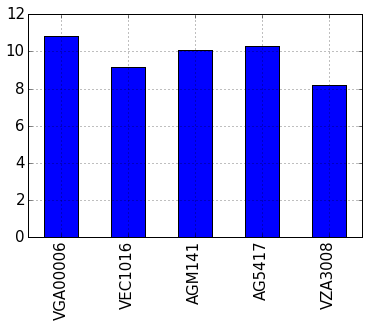

In [18]:
average_coverage.plot(kind='bar',fontsize=15)

In [19]:
stats_table = stats_table.join(average_coverage) 

In [20]:
stats_table

,short name,subspecies,total reads,percent mapped (incl. scaffolds),average coverage
ucla_id,,,,,
VGA00006,sab,sabaeus,371703956,99.433528,10.843917
VEC1016,aet,aethiops,318382728,99.315076,9.174149
AGM141,tan,tantalus,326842858,99.485537,10.082667
AG5417,pyn,pygerythrus,367646925,99.532518,10.292815
VZA3008,cyn,cynosurus,288494098,98.719793,8.195362


### vcf stats

In [21]:
def stats_dic(chrom):
    stats_fn = os.path.expanduser("~/vervet_lab/analyses/20140524_SNP_calling_ref3500_10X_individuals/"
                                "_data/snp_stats_{}.json".format(chrom))
    stats_dic = json.load(open(stats_fn,"r"))
    return stats_dic

In [22]:
chrom_dicts = [stats_dic(chrom) for chrom in chromosomes]
chrom_length = pd.read_csv(os.path.expanduser("~/vervet_lab/metadata/ref_3488.tsv"),sep="\t",index_col=0,squeeze=True)
chrom_length = chrom_length.drop(["CAEY"])

In [23]:
chrom_length.sum()

2737934092

In [24]:
autosome_stats_dic = stats_dic(autosomes[0])
for chrom in autosomes[1:]:
    stats_dic1 = stats_dic(chrom)
    for key in autosome_stats_dic:
        if key == "filters":
            for key1 in autosome_stats_dic[key]:
                autosome_stats_dic[key][key1] += stats_dic1[key][key1]
        else:
            autosome_stats_dic[key] += stats_dic1[key]

In [25]:
total_stats_dic = stats_dic(chromosomes[0])
for chrom in chromosomes[1:]:
    stats_dic1 = stats_dic(chrom)
    for key in total_stats_dic:
        if key == "filters":
            for key1 in total_stats_dic[key]:
                total_stats_dic[key][key1] += stats_dic1[key][key1]
        else:
            total_stats_dic[key] += stats_dic1[key]

In [26]:
fraction_ancestral_known = autosome_stats_dic["pass_ancestral_known"]*1./autosome_stats_dic["pass"]
print fraction_ancestral_known

0.838614046182


In [27]:
(autosome_stats_dic["pass_ancestral_is_alt"] + autosome_stats_dic["pass_ancestral_is_ref"])*1./autosome_stats_dic["pass_ancestral_known"]

0.983473161764761

In [28]:
autosome_stats_dic

{u'ancestral_known': 26368415,
 u'filters': {u'5bpIndel': 1032792,
  u'ABHet': 1063217,
  u'ExCov': 1104633,
  u'HaplotypeScore': 275988,
  u'LowCov': 866963,
  u'LowMQ': 165824,
  u'LowQual': 6093594,
  u'MQ0_10pct': 619201,
  u'QualityByDepth': 1631106,
  u'ReadPos': 546,
  u'StrandBias': 12134},
 u'indels': 0,
 u'other_variants': 0,
 u'pass': 23879699,
 u'pass_ancestral_is_alt': 6032077,
 u'pass_ancestral_is_ref': 13662810,
 u'pass_ancestral_known': 20025851,
 u'pass_ancestral_third_allele': 330964,
 u'snps': 32890729,
 u'total': 32890729}

In [29]:
total_stats_dic

{u'ancestral_known': 27197237,
 u'filters': {u'5bpIndel': 1068567,
  u'ABHet': 1103391,
  u'ExCov': 1182694,
  u'HaplotypeScore': 286745,
  u'LowCov': 898347,
  u'LowMQ': 181289,
  u'LowQual': 6295046,
  u'MQ0_10pct': 663034,
  u'QualityByDepth': 1694998,
  u'ReadPos': 561,
  u'StrandBias': 12665},
 u'indels': 0,
 u'other_variants': 0,
 u'pass': 24680030,
 u'pass_ancestral_is_alt': 6209513,
 u'pass_ancestral_is_ref': 14105508,
 u'pass_ancestral_known': 20654323,
 u'pass_ancestral_third_allele': 339302,
 u'snps': 34030040,
 u'total': 34030040}

In [30]:
mpl.rcParams["font.size"]=15

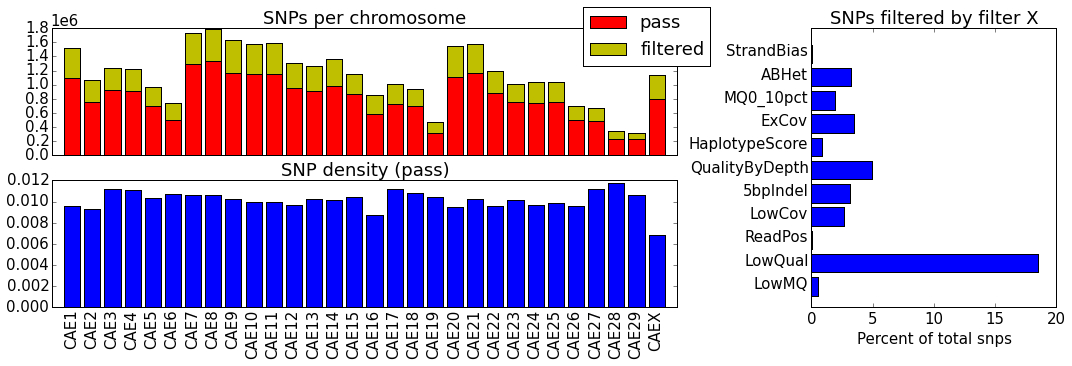

In [31]:
fig = plt.figure(1, figsize=(18,5))

ax = plt.subplot2grid((2,3), (0,0), colspan=2)



#ax = fig.add_subplot(121)
plt.title("SNPs per chromosome")
pos = np.arange(len(chrom_dicts))
snps_pass = np.array([d["pass"] for d in chrom_dicts])
snps_non_pass = [d["total"]-d["pass"] for d in chrom_dicts]
p1 = plt.bar(pos+0.1,snps_pass,width=0.8,color="r")
p2 = plt.bar(pos+0.1,snps_non_pass,width=0.8,bottom=snps_pass,color="y")
plt.legend( (p1[0], p2[0]), ('pass', 'filtered'), loc = (0.85,0.7) )
ax.yaxis.major.formatter.set_powerlimits((0,0)) 
ax.ticklabel_format(style='sci', axis='y') 
ax.set_xlim([-0.5,len(chrom_dicts)+0.5])
plt.tick_params(\
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off



ax = plt.subplot2grid((2,3), (0,2), rowspan=2) 
#ax = fig.add_subplot(122)
plt.title("SNPs filtered by filter X")
filter_data = [(k,v) for k,v in total_stats_dic["filters"].iteritems()]
filter_names = [el[0] for el in filter_data]
filter_values = [el[1] for el in filter_data]
proportions = np.array(filter_values)*100./total_stats_dic["total"]
pos = np.arange(len(proportions))
plt.barh(pos,proportions)
ax.set_yticks(pos+0.5)
ax.set_ylim([pos[0]-0.5,pos[-1]+1.5])
ax.set_yticklabels(filter_names)
ax.set_xlabel("Percent of total snps")
#ax.xaxis.major.formatter.set_powerlimits((0,0)) 
#ax.ticklabel_format(style='sci', axis='x') 
plt.tick_params(\
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off')


ax = plt.subplot2grid((2,3), (1,0), colspan=2)
plt.title("SNP density (pass)")
pos = np.arange(len(chrom_dicts))
snp_density = snps_pass*1./(chrom_length.values*fraction_not_filtered)
plt.bar(pos+0.1,snp_density,width=0.8)
ax.set_xticks(pos+0.5)
ax.set_xticklabels(chromosomes)
labels = ax.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
ax.set_xlim([-0.5,len(chrom_dicts)+0.5])

plt.tick_params(\
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')

fig.subplots_adjust(wspace=0.55)

## genotype data frames

In [32]:
%%px --local
def get_gen_df(chrom):
    fn = os.path.expanduser("~/vervet_lab/analyses/20140524_SNP_calling_ref3500_10X_individuals/"
                        "_data/GATK_UnifiedGenotyper_10Xind_ancestral_derived_{}.012".format(chrom))
    gen_df = pd.read_csv(fn,index_col=[0,1],sep="\t",na_values="N")
    gen_df.columns = meta_df.ix[gen_df.columns]["population"].values
    #add macaque
    #gen_df["mac"] = 0.
    return gen_df

### stats on the sub species

In [46]:
os.path.expanduser("~/vervet_lab/analyses/20140524_SNP_calling_ref3500_10X_individuals/"
                        "_data/GATK_UnifiedGenotyper_10Xind_ancestral_derived_{}.012".format(chrom))

'/home/GMI/hannes.svardal/vervet_lab/analyses/20140524_SNP_calling_ref3500_10X_individuals/_data/GATK_UnifiedGenotyper_10Xind_ancestral_derived_CAEX.012'

In [33]:
#local function
def reduce_stats(stats_dics):
    total_stats_dic = {}
    for k,v in stats_dics[0].iteritems():
        total_stats_dic.update({k:reduce(lambda x,y:x+y,[d[k] for d in stats_dics])})
    return total_stats_dic

In [34]:
%%px --local
#iterative version
def genotype_difference(gt0,gt1):
    #the second term accounts for heterozygote comparisons
    raise UserException("wrong: on the diagonal dont divide by 2")
    return ((gt0-gt1).abs()+(gt0==1)*(gt1==1)).sum()/2.

def pairwise_diff_mat(df):
    return pd.DataFrame({key1:{key0:genotype_difference(df[key0],df[key1]) for key0 in df} for key1 in df})

#---------------numpy version------------------
def pairwise_diff_numpy(gen_arr):
    """Squared pairwise distances between all 
    columns of 0,1,2 genotype array arr.
    This matrix based function is at least 10 
    times faster than iterating over columns.
    """
    gen_arr = gen_arr.astype(np.float64)-1
    #compare heterozygous with hom alt
    mat1 = np.where(gen_arr==0,-1,gen_arr)
    mat1[np.isnan(gen_arr)]=0
    #and hom ref
    mat2 = np.where(gen_arr==0,1,gen_arr)
    mat2[np.isnan(gen_arr)]=0
    #account for heterozygous comparisons
    mat3 = np.where(gen_arr==0,1,0)
    #don't count nan comparisons
    n = np.dot((~np.isnan(gen_arr)*1.).T,~np.isnan(gen_arr)*1.)
    B = (np.dot(mat1.T,mat1)+np.dot(mat2.T,mat2))/2.
    het = np.dot(mat3.T,mat3)
    return ((n- B)+het)/2. + np.diag(np.diag(((n- B)+het)/2.)) #self comparisons should not be divided by 2

def pairwise_diff_mat_np(df):
    """
    Calculate pairwise difference data frame.
    For Genotype 0,1,2 data frame.
    Uses numpy matrix multiplication.
    """
    diff = pairwise_diff_numpy(df.values)
    return pd.DataFrame(diff,index=df.columns,columns=df.columns)

def get_pw_diff(chrom):
    gen_df = get_gen_df(chrom)
    return pairwise_diff_mat(gen_df)

gen_df_funs = {"total_snps": lambda gen_df: len(gen_df),
              "snps_per_subpop": lambda gen_df: (gen_df == 1).sum(axis=0),
              "fixed_diff_to_ref": lambda gen_df: (gen_df.sum(axis=1)==2*gen_df.shape[1]).sum(),
              "pairwise_diff_mat": lambda gen_df: pairwise_diff_mat_np(gen_df),
              "derived_alleles": lambda gen_df: gen_df.sum(axis=0)}
def get_stats(chrom):
    gen_df = get_gen_df(chrom)
    stats_dic = {}
    for n,v in gen_df_funs.iteritems():
        stats_dic.update({n:v(gen_df)})
    return stats_dic



In [35]:
stats_dics = lv.map_async(get_stats, autosomes)

In [37]:
stats_dics.wait(10)

In [38]:
total_stats = reduce_stats(stats_dics.get())

In [41]:
total_stats

{'derived_alleles': pyn    11452702
 tan    11328831
 aet    11415279
 sab    11261851
 cyn    11051958
 dtype: float64,
 'fixed_diff_to_ref': 121992,
 'pairwise_diff_mat':            pyn        tan        aet        sab        cyn
 pyn  4073196.0  6030851.0  6496416.5  7564638.0  4702763.5
 tan  6030851.0  3944089.0  6509592.0  7212377.5  5851541.0
 aet  6496416.5  6509592.0  1911259.0  7738523.0  6296261.5
 sab  7564638.0  7212377.5  7738523.0  3042179.0  7332659.5
 cyn  4702763.5  5851541.0  6296261.5  7332659.5  3239522.0,
 'snps_per_subpop': pyn    4073196
 tan    3944089
 aet    1911259
 sab    3042179
 cyn    3239522
 dtype: int64,
 'total_snps': 19694887}

In [39]:
stats_table

,short name,subspecies,total reads,percent mapped (incl. scaffolds),average coverage
ucla_id,,,,,
VGA00006,sab,sabaeus,371703956,99.433528,10.843917
VEC1016,aet,aethiops,318382728,99.315076,9.174149
AGM141,tan,tantalus,326842858,99.485537,10.082667
AG5417,pyn,pygerythrus,367646925,99.532518,10.292815
VZA3008,cyn,cynosurus,288494098,98.719793,8.195362


In [ ]:
total_stats

#### make three categories of SNPs: fixed differences, within species snps, shared snps

In [58]:
chrom = "CAE28"
gen_df = get_gen_df(chrom)[subspecies]

In [42]:
%%px --local
def get_variant_categories_chrom(chrom):
    gen_df = get_gen_df(chrom)[subspecies]
    return get_variant_categories(gen_df)
    
def get_variant_categories(gen_df):
    variant_categories = {"total":len(gen_df),
                          "fixed_diff":(gen_df!=1).all(axis=1).sum(),
                          "shared_variants" : ((gen_df==1).sum(axis=1)>=2).sum(),
                          "private_variants": ((gen_df.sum(axis=1)==1)|(gen_df.sum(axis=1)==2*gen_df.shape[1]-1)).sum()
                          }
    #the rest is seggragating on one and fixed between other subpopulations
    return variant_categories

In [43]:
map_variant_cats = lv.map_async(get_variant_categories_chrom,autosomes)

In [44]:
variant_categories = reduce_stats(map_variant_cats.get())

In [45]:
print "fraction fixed diff:",variant_categories["fixed_diff"]*1./variant_categories["total"]
print "fraction shared variants:",variant_categories["shared_variants"]*1./variant_categories["total"]
print "fraction private variants:",variant_categories["private_variants"]*1./variant_categories["total"]
print "fraction fixed across some, seggregating in others:",(variant_categories["total"]-\
                                variant_categories["private_variants"]-\
                                variant_categories["fixed_diff"]-\
                                variant_categories["shared_variants"]*1.)/variant_categories["total"]

fraction fixed diff: 0.360225879945
fraction shared variants: 0.147410695984
fraction private variants: 0.359858068746
fraction fixed across some, seggregating in others: 0.132505355324


#### check for fixed differences that are inconsistent with tree topoplogy

In [96]:
topology = (("sab",),("aet",("tan",("pyn","cyn"))))

In [122]:
monophyla = (("pyn","cyn"),("tan","pyn","cyn"),("aet","tan","pyn","cyn"))

In [85]:
chrom = "CAE28"
gen_df = get_gen_df(chrom)

In [117]:
fixed_diff = gen_df[(gen_df!=1).all(axis=1)&(gen_df.mean(axis=1)!=2)]

In [ ]:
fixed

In [86]:
import itertools

In [134]:
#here we look at all non-monophyletic species groups
#snps who are differentially fixed in these groups are expected to seggregate along the tree
#we don't make use of ancestral/derived info from macaque here
inconsistent_fixed = 0
for partition in [set(l)  for i in range(2,len(subspecies)) for l in itertools.combinations(subspecies,i)]:
    if partition not in [set(i) for i in monophyla]:
        rest = set([s for s in subspecies if s not in partition])
        if rest not in [set(i) for i in monophyla] and len(rest)>1:
            inconsistent_fixed += ((fixed_diff[list(partition)].mean(axis=1)==0)&(fixed_diff[list(rest)].mean(axis=1)==2)).sum()

In [136]:
inconsistent_fixed*1./len(fixed_diff)

0.15593573706156488

In [ ]:
-> at least 16% of the fixed differences are expected to have seggregates along branches and might still seggregate within subspecies

#### pairwise difference, phylogenetic tree

In [48]:
pw_diff = total_stats["pairwise_diff_mat"]

In [49]:
generation_time=8.5
mutation_rate=1.5*10**(-8)

genome_size=2.545*10**9*fraction_not_filtered 
coal_time = pw_diff*generation_time/(2*genome_size*mutation_rate)

In [52]:
(total_stats["pairwise_diff_mat"]/genome_size)

,pyn,tan,aet,sab,cyn
pyn,0.001778,0.002633,0.002836,0.003303,0.002053
tan,0.002633,0.001722,0.002842,0.003149,0.002555
aet,0.002836,0.002842,0.000834,0.003379,0.002749
sab,0.003303,0.003149,0.003379,0.001328,0.003201
cyn,0.002053,0.002555,0.002749,0.003201,0.001414


In [83]:
total_stats["pairwise_diff_mat"].applymap(round)

,pyn,tan,aet,sab,cyn
pyn,4073196,6030851,6496417,7564638,4702764
tan,6030851,3944089,6509592,7212378,5851541
aet,6496417,6509592,1911259,7738523,6296262
sab,7564638,7212378,7738523,3042179,7332660
cyn,4702764,5851541,6296262,7332660,3239522


In [145]:
total_stats["pairwise_diff_mat"].to_csv(
                os.path.join(output_folder,"pairwise_diff_10x_macaque.tsv"),sep="\t")

In [59]:
total_stats["snps_per_subpop"]

pyn    4073196
tan    3944089
aet    1911259
sab    3042179
cyn    3239522
dtype: int64

In [60]:
snps_per_sp = total_stats["snps_per_subpop"].copy()*100./genome_size
snps_per_sp.name = "heterozygosity (%)"
snps_per_sp.index = [ucla_ids[subspecies.index(s)] for s in snps_per_sp.index]
stats_table = stats_table.join(snps_per_sp) 

In [61]:
derived_alleles = total_stats["derived_alleles"].copy()/10.**6
derived_alleles.name = "derived alleles (million)"
derived_alleles.index = [ucla_ids[subspecies.index(s)] for s in derived_alleles.index]
stats_table = stats_table.join(derived_alleles) 

In [62]:
stats_table[["average coverage","percent mapped\n(incl. scaffolds)","heterozygosity (%)","derived alleles (million)"]] = stats_table[["average coverage","percent mapped\n(incl. scaffolds)","heterozygosity (%)","derived alleles (million)"]].applymap(lambda x: round(100.*x)/100)

In [63]:
eff_popsize = pd.Series([pw_diff.iloc[i,i] for i in range(len(pw_diff))],index=pw_diff.index)/(4.*mutation_rate*genome_size)

In [64]:
eff_popsize

pyn    29638.332242
tan    28698.893982
aet    13907.145456
sab    22136.207524
cyn    23572.160373
mac        0.000000
dtype: float64

In [67]:
stats_table

,short name,subspecies,total reads,percent mapped (incl. scaffolds),average coverage,heterozygosity (%),derived alleles (million)
ucla_id,,,,,,,
VGA00006,sab,sabaeus,371703956,99.43,10.84,0.13,11.26
VEC1016,aet,aethiops,318382728,99.32,9.17,0.08,11.42
AGM141,tan,tantalus,326842858,99.49,10.08,0.17,11.33
AG5417,pyn,pygerythrus,367646925,99.53,10.29,0.18,11.45
VZA3008,cyn,cynosurus,288494098,98.72,8.20,0.14,11.05


In [76]:
coal_time.to_excel(jn(output_folder,"coalescent_time.xls"))

In [78]:
coal_time.applymap(round)

,pyn,tan,aet,sab,cyn
pyn,503852,746012,803602,935741,581729
tan,746012,487881,805232,892166,723832
aet,803602,805232,236421,957250,778843
sab,935741,892166,957250,376316,907045
cyn,581729,723832,778843,907045,400727


In [79]:
split_time =coal_time.copy()
split_time.iloc[:,:]=np.nan
for i in range(coal_time.shape[0]):
    for j in range(coal_time.shape[1]):
        split_time.iloc[i,j]=coal_time.iloc[i,j]-(coal_time.iloc[i,i]+coal_time.iloc[j,j])/2

In [81]:
split_time.applymap(round)

,pyn,tan,aet,sab,cyn
pyn,0,250146,433466,495657,129440
tan,250146,0,443081,460068,279528
aet,433466,443081,0,650882,460269
sab,495657,460068,650882,0,518524
cyn,129440,279528,460269,518524,0


In [ ]:
        sab     aet     tan     pyn     cyn
sab     0.0     650881.6706687041       460067.9582332824       495657.1236265735       518523.9976715419
aet     650881.6706687041       0.0     443080.8848140872       433465.8589827548       460269.2789056247
tan     460067.9582332824       443080.8848140872       0.0     250145.85243396636      279527.7850542094
pyn     495657.1236265735       433465.8589827548       250145.85243396636      0.0     129439.5437677363
cyn     518523.9976715419       460269.2789056247       279527.7850542094       129439.5437677363       0.0

In [167]:
coal_time.ix[subspecies,subspecies].to_csv(
                os.path.join(output_folder,"coal_time_10x.tsv"),sep="\t")
split_time.to_csv(
                os.path.join(output_folder,"split_time_10x_macaque.tsv"),sep="\t")
split_time.ix[subspecies,subspecies].to_csv(
                os.path.join(output_folder,"split_time_10x.tsv"),sep="\t")

In [19]:
from Bio import Phylo

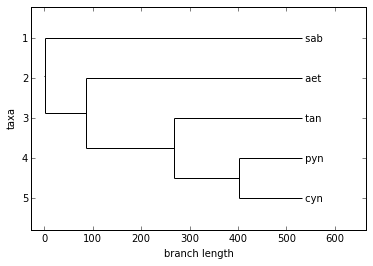

In [23]:
split_tree = Phylo.read(os.path.join(output_folder,"UPGMA_tree_10x.newick"),"newick")
#split_tree.ladderize()   # Flip branches so deeper clades are displayed at top
Phylo.draw(split_tree)

In [25]:
dir(split_tree)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filter_search',
 'as_phyloxml',
 'clade',
 'collapse',
 'collapse_all',
 'common_ancestor',
 'count_terminals',
 'depths',
 'distance',
 'find_any',
 'find_clades',
 'find_elements',
 'format',
 'from_clade',
 'get_nonterminals',
 'get_path',
 'get_terminals',
 'id',
 'is_bifurcating',
 'is_monophyletic',
 'is_parent_of',
 'is_preterminal',
 'is_terminal',
 'ladderize',
 'name',
 'prune',
 'randomized',
 'root',
 'root_at_midpoint',
 'root_with_outgroup',
 'rooted',
 'split',
 'total_branch_length',
 'trace',
 'weight']

In [34]:
split_tree.get_clade()

AttributeError: 'Tree' object has no attribute 'get_clade'

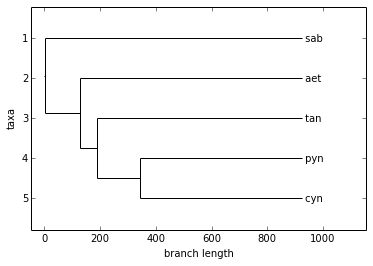

In [170]:
#IGNORING WITHIN SUBSPECIES DIVERSITY
#this is average coalescent times -> splits get older, this is expected
rooted_split_tree = Phylo.read(os.path.join(output_folder,"UPGMA_tree_10x_coal_time.newick"),"newick")
rooted_split_tree.ladderize()   # Flip branches so deeper clades are displayed at top
Phylo.draw(rooted_split_tree)

In [36]:
os.path.join(output_folder,"UPGMA_tree_10x_coal_time.newick")

'/home/GMI/hannes.svardal/vervet_project/analyses/20140524_SNP_calling_ref3500_10X_individuals/output/UPGMA_tree_10x_coal_time.newick'

### Comparison to macaque

In [ ]:
data from Yan et al 2011, Nature Biotechnology, doi:10.1038/nbt.1992

In [ ]:
ir... indian rhesus
cr... chinese rhesus
ce... crab eating macaque

In [54]:
ir_fixed = 1655269
ir_singletons = 4292081
cr_fixed = 818025
cr_singletons = 4046387
ce_fixed = 2142312
ce_singletons = 5369137
ce_cr = 677956
ce_ir = 185412
cr_ir = 336580
ce_cr_ir = 1415712

In [67]:
total = ir_fixed + ir_singletons + cr_fixed + cr_singletons + ce_fixed + ce_singletons + ce_cr + ce_ir + cr_ir + ce_cr_ir
print total

20938871


In [58]:
singletons = (ir_singletons + cr_singletons + ce_singletons)*1./total
print singletons

0.654648715301


In [60]:
fixed_diff = (ir_fixed + cr_fixed + ce_fixed)*1./total
print fixed_diff

0.220432419685


In [64]:
(ir_singletons + cr_singletons + ce_singletons+ce_cr+ce_ir+cr_ir)*1./total

0.7119559120451145

In [66]:
(ce_cr + ce_ir + cr_ir + ce_cr_ir)*1./total

0.12491886501425985

## MSMC

In [11]:
%%px --local
#take the sites from df but add the genotypes from phase df
def make_phased_input(id):
    errors = []
    for chrom in autosomes:
        try:
            df = pd.read_csv(jn(msmc_ana_dir,"msmc_input_{}_{}.tsv".format(id,chrom)),sep="\t",index_col=[0,1],header=None)
            #phase df can have some more entries (sites where the genotype is missing in the original df)
            phase_df = pd.read_csv(jn(msmc_ana_dir,"msmc_input_{}_beagle_{}.tsv".format(id,chrom)),sep="\t",index_col=[0,1],header=None)
            df[3] = phase_df.ix[df.index][3]
            #attention this is not correct, since the distance for the dropped values should be added to the ones above
            df.dropna(inplace=True)
            df.to_csv(jn(msmc_ana_dir,"msmc_input_{}_phased_{}.tsv".format(id,chrom)),sep="\t",header=None)
        except Exception, e:
            errors.append(str(e))
    return errors

In [12]:
map_make_phased = lv.map_async(make_phased_input, ucla_ids)

In [15]:
map_make_phased.wait(10)

In [16]:
map_make_phased.result

[[], [], [], [], []]

In [29]:
chrom = 'CAE28'
id = 'VZA3008'

In [30]:
df = pd.read_csv(jn(msmc_ana_dir,"msmc_input_{}_{}.tsv".format(id,chrom)),sep="\t",index_col=[0,1],header=None)

In [31]:
beagle_df = pd.read_csv(jn(msmc_ana_dir,"msmc_input_{}_beagle_{}.tsv".format(id,chrom)),sep="\t",index_col=[0,1],header=None)

In [35]:
phased_df = pd.read_csv(jn(msmc_ana_dir,"msmc_input_{}_phased_{}.tsv".format(id,chrom)),sep="\t",header=None,index_col=[0,1])

### Plot results

In [17]:
mpl.rcParams["font.size"]=16

In [18]:
mpl.rc('text', usetex=False)

In [19]:
converter =  mpl.colors.ColorConverter()
mu=1.5e-8
generation_time = 8.5
colors3 = ["blue","magenta","cyan","green","orange","yellow","brown","red"]
light_colors3 = [tuple([min(1,v) for v in  np.array(converter.to_rgb(c))+0.1]) for c in colors3] 
pops3 = ["aet","cyn","pyn","pys","sab","sac","sar","tan"]
populations = ["C. a. aethiops","C. a. cynosuros","C. a. pygerythrus","pys","C. a.sabaeus","sac","sar","C.a. tantalus"]
pops = ["C. a. aethiops","C. a. cynosurus","C. a. pygerythrus","C. a. sabaeus","C. a. tantalus"]

In [20]:
colors = [(98,109,176),(10,176,235),(72,159,84),(245,142,55),(228,70,90)]
colors = [[c/255. for c in k] for k in colors]

In [17]:
[[c/255. for c in k] for k in colors]

[[0.3843137254901961, 0.42745098039215684, 0.6901960784313725],
 [0.03529411764705882, 0.06666666666666667, 0.12549019607843137],
 [0.2823529411764706, 0.6235294117647059, 0.32941176470588235],
 [0.9607843137254902, 0.5568627450980392, 0.21568627450980393],
 [0.8941176470588236, 0.27450980392156865, 0.35294117647058826]]

In [19]:
colors = converter.to_rgba_array()

In [32]:
[i sorted((e,i) for i,e in enumerate(subspecies))

[('aet', 1), ('cyn', 4), ('pyn', 3), ('sab', 0), ('tan', 2)]

In [33]:
sorted((e,i) for i,e in enumerate(subspecies))

[('aet', 1), ('cyn', 4), ('pyn', 3), ('sab', 0), ('tan', 2)]

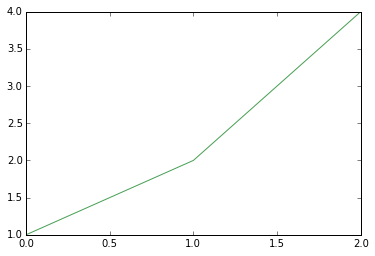

In [46]:
plt.plot([1,2,4],color=(0.2823529411764706, 0.6235294117647059, 0.32941176470588235))

In [13]:
mpl.rcParams['svg.fonttype'] = 'none'

aet [0.3843137254901961, 0.42745098039215684, 0.6901960784313725]
cyn [0.0392156862745098, 0.6901960784313725, 0.9215686274509803]
pyg [0.2823529411764706, 0.6235294117647059, 0.32941176470588235]
sab [0.9607843137254902, 0.5568627450980392, 0.21568627450980393]
tan [0.8941176470588236, 0.27450980392156865, 0.35294117647058826]


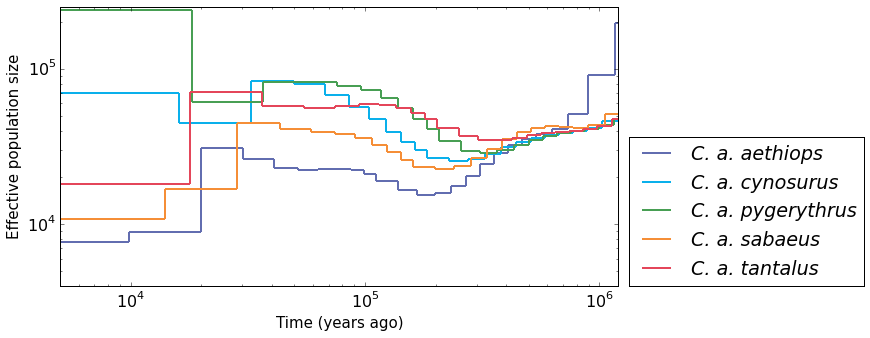

In [28]:
# Two haplotypes
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
#jet = cm = plt.get_cmap('jet') 
#cNorm  = mpl.colors.Normalize(vmin=0, vmax=len(ids))
#scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)
for i,(pop,ix) in enumerate(sorted((e,i) for i,e in enumerate(subspecies))):
    id = ucla_ids[ix]
    print mt.ix[id]['population'], colors[i]
    #colorVal = scalarMap.to_rgba(i)
    #pop = populations[pops3.index(mt.ix[id.split("_")]["population"].values[0])]
    time_df = pd.read_csv(jn(msmc_ana_dir,"msmc_out_{}.final.txt".format(id)),sep="\t",index_col=0)
    time_df = time_df#.iloc[:-4]
    time_df[["left_time_boundary","right_time_boundary"]] = time_df[["left_time_boundary","right_time_boundary"]]*generation_time/mu
    time_df["Ne"] = 1/(2*mu*time_df["lambda_00"])
    lines = [[(el[1]["left_time_boundary"],el[1]["Ne"]),(el[1]["right_time_boundary"],el[1]["Ne"])] for el in time_df.iterrows()]
    lines += [[e0[1],e1[0]] for e0,e1 in zip(lines,lines[1:])]
    #c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
    lc = mpl.collections.LineCollection(lines, linewidths=2,label=pops[i],color=colors[i]) 
    ax.add_collection(lc)
ax.autoscale()
ax.margins(0.05)
ax.set_xlim([5000,1.2*10**6])
ax.set_ylim([4000,250000])
ax.set_xscale('log')
ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
l = plt.legend(loc=(1.02,0),prop={'style':'italic'})
#plt.title("MSMC highest coverage individual (2 haplotypes)")
ax.set_xlabel("Time (years ago)",fontdict={'size':'15'})
ax.set_ylabel("Effective population size",fontdict={'size':'15'})

#plt.savefig(jn(figure_dir,"msmc_10x_ind_v2.pdf"),bbox_inches='tight',bbox_extra_artists=(l,))

aet [0.3843137254901961, 0.42745098039215684, 0.6901960784313725]
cyn [0.0392156862745098, 0.6901960784313725, 0.9215686274509803]
pyg [0.2823529411764706, 0.6235294117647059, 0.32941176470588235]
sab [0.9607843137254902, 0.5568627450980392, 0.21568627450980393]
tan [0.8941176470588236, 0.27450980392156865, 0.35294117647058826]


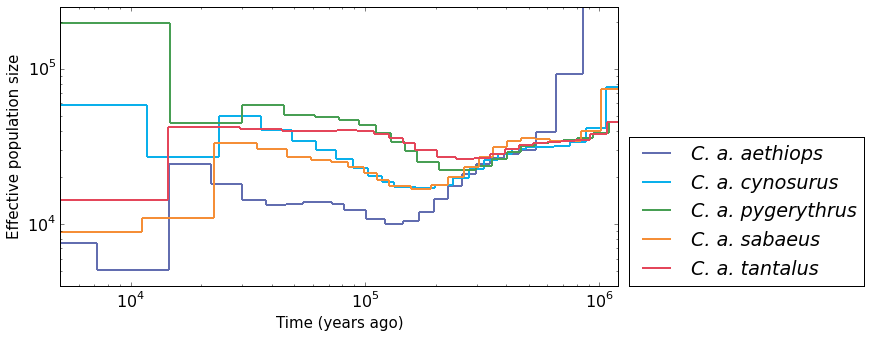

In [23]:
# Two haplotypes
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
#jet = cm = plt.get_cmap('jet') 
#cNorm  = mpl.colors.Normalize(vmin=0, vmax=len(ids))
#scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)
for i,(pop,ix) in enumerate(sorted((e,i) for i,e in enumerate(subspecies))):
    id = ucla_ids[ix]
    print mt.ix[id]['population'], colors[i]
    #colorVal = scalarMap.to_rgba(i)
    #pop = populations[pops3.index(mt.ix[id.split("_")]["population"].values[0])]
    time_df = pd.read_csv(jn(msmc_ana_dir,"msmc_out_{}.final.txt".format(id)),sep="\t",index_col=0)
    time_df = time_df#.iloc[:-4]
    time_df[["left_time_boundary","right_time_boundary"]] = time_df[["left_time_boundary","right_time_boundary"]]*generation_time/mu
    time_df["Ne"] = 1/(2*mu*time_df["lambda_00"])
    lines = [[(el[1]["left_time_boundary"],el[1]["Ne"]),(el[1]["right_time_boundary"],el[1]["Ne"])] for el in time_df.iterrows()]
    lines += [[e0[1],e1[0]] for e0,e1 in zip(lines,lines[1:])]
    #c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
    lc = mpl.collections.LineCollection(lines, linewidths=2,label=pops[i],color=colors[i]) 
    ax.add_collection(lc)
ax.autoscale()
ax.margins(0.05)
ax.set_xlim([5000,1.2*10**6])
ax.set_ylim([4000,250000])
ax.set_xscale('log')
ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
l = plt.legend(loc=(1.02,0),prop={'style':'italic'})
#plt.title("MSMC highest coverage individual (2 haplotypes)")
ax.set_xlabel("Time (years ago)",fontdict={'size':'15'})
ax.set_ylabel("Effective population size",fontdict={'size':'15'})

plt.savefig(jn(figure_dir,"msmc_10x_ind.pdf"),bbox_inches='tight',bbox_extra_artists=(l,))

In [35]:
mt.ix[ucla_ids][['latitude','longitude']]

,latitude,longitude
ucla_id,,
VGA00006,13.389000,-16.653383
VEC1016,11.595817,37.407183
AGM141,4.366667,18.583333
AG5417,-7.000000,35.000000
VZA3008,-14.978317,25.993217


In [5]:
from mpl_toolkits.basemap import Basemap

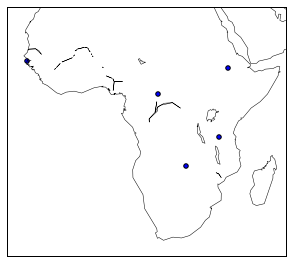

In [17]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
m = Basemap(llcrnrlon=-22 ,llcrnrlat=-39, urcrnrlon= 53,urcrnrlat=28, resolution='c',ax=ax)
m.drawcoastlines(0.5)
#for long,lat in mt.ix[ucla_ids][['longitude','latitude']].iteritems():
#    print long, lat
ax.scatter(mt.ix[ucla_ids][['longitude']],mt.ix[ucla_ids][['latitude']])

In [ ]:
        long = mt[mt['pop3']==p]['longitude'].values
        lat = mt[mt['pop3']==p]['latitude'].values   
        ax0.scatter(long,lat,s=400, marker=align_marker('v', valign='bottom'),
                    alpha=1,facecolor=color,lw=1)